## GoogLeNet (含并行连接的网络)

GoogLeNet网络结构在2014年的ImageNet图像识别挑战赛中大放异彩，GoogLeNet吸收了NiN串联网络的思想，并提出有时使用不同大小的卷积核组合是有利的。

**Inception**块是GoogLeNet中基本的卷积块。Inception块相当于一个有4条路径的子网络，它通过不同窗口形状的卷积层和最大聚合层来并行抽取信息，使用$1\times 1$的卷积核减少通道数从而降低模型复杂度。四条通路并联使用合适的填充使得输入和输出的高宽保持一致，最后将每条线路的输出在通道维度上连接，构成Inception块的输出。超参数为每层输出通道数。

Inception

![](https://zh-v2.d2l.ai/_images/inception.svg)


GooLeNet一共使用9个Inception块和1个全局汇聚层。

![](https://zh-v2.d2l.ai/_images/inception-full.svg)



In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1) # 在通道维度上合并

In [ ]:
# 第一个模块使用64个通道和7x7的卷积层实现
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
           nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# 第二个模块使用两个卷积，第一个是64通道1x1的卷积层，第二个是将通道数增加三倍的3x3卷积层
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
           nn.Conv2d(64, 192, kernel_size=3, padding=1),
           nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第三个模块串联了两个Inception块：

第一个Inception的输出通道数为64+128+32+32 = 256，四条路径的通道数之比为2：4：1：1，第二条和第三条路径首先将通道数减小到96/192=1/2和16/192=1/12，然后连接第二个卷积层。

第二个Inception的输出通道数增加到128+192+96+64=480，四条路经的通道数之比为128：192：96：64=4：6：3：2，第二条路径和第三条路径首先将通道数减小到128/256=1/2和32/256=1/8。

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
           Inception(256, 128, (128, 192), (32, 96), 64),
           nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四个模块包含了5个Inception块：

第一个Inception的输出通道为：192+208+48+64=512。

第二个Inception的输出通道为：160+224+64+64=512。

第三个Inception的输出通道为：128+256+64+64=512。

第四个Inception的输出通道为：112+288+64+64=528。

第五个Inception的输出通道为：256+320+128+128=832。

这些Inception和第三模块的类似，都是包含3x3的卷积层的第二条路径输出通道数最多，其次是1x1卷积层的第一条路径，之后是5x5卷积层的第四三条路径和包含3x3最大汇聚层的第四条路经。其中第二条和第三条路径先按比例减小通道数，这些比例和第三模块不同。

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
           Inception(512, 160, (112, 224), (24, 64), 64),
           Inception(512, 128, (128, 256), (24, 64), 64),
           Inception(512, 112, (144, 288), (32, 64), 64),
           Inception(528, 256, (160, 320), (32, 128), 128),
           nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五个模块包含两个Inception块：

第一个Inception的输出通道数为：256+320+128+128=832。

第二个Inception的输出通道数为：384+384+128+128=1024。

第五模块后紧跟一个输出层，该模块和NiN一样使用一个全局平均汇聚层，将每个通道数的高和块变为1，最后街上一个输出个数为标签类别数的全连接层。

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (96, 320), (16, 128), 128),
           Inception(832, 384, (112, 384), (24, 128), 128),
           nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(X.__class__.__name__, 'output shape:\t', X.shape)

Tensor output shape:	 torch.Size([1, 64, 24, 24])
Tensor output shape:	 torch.Size([1, 192, 12, 12])
Tensor output shape:	 torch.Size([1, 480, 6, 6])
Tensor output shape:	 torch.Size([1, 832, 3, 3])
Tensor output shape:	 torch.Size([1, 1024])
Tensor output shape:	 torch.Size([1, 10])


In [ ]:
!nvidia-smi

Wed Jul 28 13:51:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

loss 0.247, train acc 0.905, test acc 0.882
1403.8 examples/sec on cuda:0


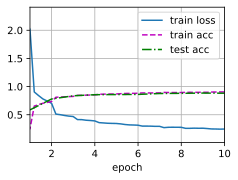

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# 8m19s